<img src="../../Img/backdrop-wh.png" alt="Drawing" style="width: 300px;"/>

# Topic Modeling

* * * 

<div class="alert alert-success">  
    
### Learning Objectives 
    
* Understand topic modeling and how it can be used to find themes and topics across posts.
* Visualize topic models to facilitate exploration.
* Evaluate and improve topic models using several methods.
* Give names to topics, and use them to classify text.
</div>

### Icons Used in This Notebook
🔔 **Question**: A quick question to help you understand what's going on.<br>
💡 **Tip**: How to do something a bit more efficiently or effectively.<br>
⚠️ **Warning:** Heads-up about tricky stuff or common mistakes.<br>
💭 **Reflection**: Reflecting on ethical implications, biases, and social impact in data science.<br>

### Sections
1. [Topic Modeling](#topic)
2. [Visualizing a Topic Model](#vis)
3. [Tweaking the Data](#data)
4. [Tweaking Hyperparameters](#hyper)
5. [Calculating Topic Coherence](#coh)
6. [Changing Amount of Topics](#topics)
7. [Using Topic Models](#use)

<a id='topic'></a>

# Topic modeling

This notebook introduces topic modeling. Topic modeling is a type of statistical modeling for the discovery of abstract "topics" that occur in a collection of documents. It is frequently used in NLP to aid the discovery of hidden semantic structures in a collection of texts.

Before you start, please read [this post](https://tomvannuenen.medium.com/analyzing-reddit-communities-with-python-part-5-topic-modeling-a5b0d119add) for an explainer of how topic modeling (and LDA, which is just one form of topic modeling) works.

We'll use the `Gensim` package to create our topic models, which also allows us to run tests to optimize our topic amount.

## Loading the data

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../../data/aita_pp.csv')

Let's split up the lemmas--we need them split up to use in our topic model. All we need to do is run `.split()` on our "pp_text" column to tokenize the data again.

In [2]:
lemmas_split = [lemma.split() for lemma in df['pp_text']]

In [3]:
lemmas_split[0][:10]

['girlfriend',
 'recently',
 'went',
 'beach',
 'friends',
 'tiny',
 'bikini',
 'basically',
 'thong',
 'hate']

## Creating a `Dictionary` with Gensim

Now, let's create our gensim dictionary - a mapping of each word to a unique id – a Document-Term matrix – much like the `CountVectorizer` we saw last week. We'll use gensim's `Dictionary` class for this.

In [4]:
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel

# Create Dictionary 
dictionary = corpora.Dictionary(lemmas_split)

# filter extremes and assign new ids
dictionary.filter_extremes(no_below=10, no_above=0.4)
dictionary.compactify() 

# SAVE DICT
dictionary.save('../../data/aita_lda.dict')

# Create Document-Term Matrix of our whole corpus 
corpus = [dictionary.doc2bow(text) for text in lemmas_split]

Topic modeling uses a **bag-of-words** model to represent documents in a corpus. In the bag-of-words model, a document is represented by word counts. Additional information, such as word order, is discarded.

Let's view some of the corpus we have now:

In [5]:
corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 2),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 6),
 (7, 1),
 (8, 1),
 (9, 1)]

Observe the first 10 tuples above. Each consists of words with a unique id. This a mapping of (word_id, word_frequency). For example, (0, 1) above demonstrates that word id 0 occurs once in the first document. Word id 6 occurs 6 times, and so on. This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [6]:
dictionary[6]

'ass'

And if you want to see the associated id for some word:

In [7]:
dictionary.token2id['father']

2083

## Running a model

Let's run our first Gensim LDA topic model! Check out the comments to learn about the function arguments we're using.

Note that topic modeling essentially adds a third latent layer on top of the documents and tokens (which is the representation we saw last week when running SKLearn's `CountVectorizer()`. That third layer consists of topics. Topic modeling assumes that documents are made of topics, and topics is made up of tokens. It also assumes a Dirichlet probability distribution, which encourages docs to only consist of a handful of topics and topics only of a handful of words.

In [8]:
from gensim.models.ldamodel import LdaModel

%time
lda_model = LdaModel(corpus=corpus,   # stream of document vectors or sparse matrix of shape
            id2word=dictionary,       # mapping from word IDs to words (for determining vocab size)
            num_topics=10,            # amount of topics
            random_state=100,         # seed to generate random state; useful for reproducibility
            passes=2,                 # amount of iterations/epochs 
            per_word_topics=False)    # computing most-likely topics for each word 

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.91 µs


The most challenging part about topic modeling is creating a *good*, i.e. interpretable, topic model. This is a heavily iterative process. The first thing we should do is visualize the model.

<a id='vis'></a>

# Visualizing a Topic Model

One of the best ways to visualize a topic model is through the pyLDAvis package. `pyLDAvis` was designed to help users interpret the topics in a topic model. Let's start by downloading the package.

In [9]:
try:
    import pyLDAvis
except ImportError:
    %pip install pyLDAvis

PyLDAvis allows us to visualize our topics. A "good" topic model produces non-overlapping, fairly large bubbles, which should be scattered throughout the chart instead of being clustered in one quadrant. A model with too many topics will typically have many overlaps, small sized bubbles clustered in one region of the chart.

In [10]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, dictionary)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.042964 -0.046510       1        1  17.272570
4     -0.125474  0.041119       2        1  13.074211
6     -0.004271  0.107581       3        1  12.037647
7      0.047645 -0.023222       4        1  11.989317
0     -0.099604  0.063588       5        1  10.974098
2     -0.016019  0.056106       6        1   9.281929
1     -0.050710 -0.173337       7        1   8.070237
9      0.083722 -0.043413       8        1   6.686996
8     -0.060042 -0.031065       9        1   6.628441
5      0.181788  0.049152      10        1   3.984553, topic_info=          Term          Freq         Total Category  logprob  loglift
40    daughter   8402.000000   8402.000000  Default  30.0000  30.0000
2120   wedding   5711.000000   5711.000000  Default  29.0000  29.0000
882       baby   6281.000000   6281.000000  Default  28.0000  28.0000
323       kids  11082.000000  11082.000000  Default  27.0000  27.0000
981    husband  12166.000000  12166.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
167      thing    289.317174   5146.134895  Topic10  -5.7168   0.3443
438        bad    282.537809   4511.473106  Topic10  -5.7406   0.4522
186        way    287.796061   6569.786733  Topic10  -5.7221   0.0948
471     pretty    270.932793   4335.279700  Topic10  -5.7825   0.4501
78        left    271.644313   6213.036882  Topic10  -5.7799   0.0928

[868 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2523      1  0.033001         $
2523      2  0.049665         $
2523      3  0.000327         $
2523      4  0.158796         $
2523      5  0.004901         $
...     ...       ...       ...
280       4  0.004755  youngest
280       5  0.760754  youngest
280       6  0.009509  youngest
280       7  0.014264  youngest
280       9  0.017434  youngest

[3177 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 7, 8, 1, 3, 2, 10, 9, 6])

On the left, there is a 2D plot of the "distance" between all of the topics (labeled as the Intertopic Distance Map). This plot uses a multidimensional scaling (MDS) algorithm. 
- Similar topics should appear close together on the plot; dissimilar topics should appear far apart. 
- The relative size of a topic's circle in the plot corresponds to the relative frequency of the topic in the corpus.

### Exploring topics and words
- You can scrutinize a topic more closely by clicking on its circle, or entering its number in the "selected topic" box in the upper-left (Note that, though the data used by gensim and pyLDAvis are the same, they don't use the same ID numbers for topics.)
- If you roll your mouse over a term in the bar chart on the right, the topic circles will resize in the plot on the left. This shows the strength of the relationship between the topics and the selected term.

### Salience
On the right, there is a bar chart with the top terms. When no topic is selected in the plot on the left, the bar chart shows the top-30 most **salient** terms in the corpus. A term's saliency is a measure of both how frequent the term is in the corpus and how "distinctive" it is in distinguishing between different topics.

### Probability Vs Exclusivity 
When you select a particular topic, this bar chart changes to show the top-30 most "relevant" terms for the selected topic. The relevance metric is controlled by the parameter λ, which can be adjusted with a slider above the bar chart:

* Setting λ close to 1.0 (the default) will rank the terms according to their probability within the topic.
* Setting λ close to 0.0 will rank the terms according to their "distinctiveness" or "exclusivity" within the topic. This means that terms that occur only in this topic, and do not occur in other topics.

You can move the slider between 0.0 and 1.0 to weigh term probability and exclusivity.

### Exploring the graph
The interactive visualization pyLDAvis produces is helpful for **individual** topics: you can manually select each topic to view its top most frequent and/or "relevant" terms, using different values of the λ parameter. This can help when you're trying to assign a name or "meaning" to each topic. 

It also helps you to see the **relationships** between topics: exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

### Getting insights about the model
As you can see, this model probably has too many topics: they are overlapping, and most of them appear in one corner of the graph. So we have our first hint that we might want to alter our model. Let's start by tweaking our data.

<a id='data'></a>

# Tweaking the data

Remember we used the lemmas of our dataset? What if we tweaked it some more -- for instance, by POS tagging?

POS - Part of Speech - tagging is the process of marking up a word in a corpus to a corresponding part of a speech tag (noun, adjective, verb, etc.). Often it is a process of converting a sentence to a list of tuples where each tuple takes the form of (word, tag).

Let's do this with spaCy.

In [11]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

import spacy
#!spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

def POS(text, allowed_postags = ['NOUN', 'ADJ']):
    parsed = nlp(text)
    return [token.lemma_ for token in parsed if token.pos_ in allowed_postags]

In [ ]:
# turn our POS tagged lemmas into a string so we can save them in our DF
str_pos_lemmas = [' '.join(t) for t in lemmas_split]

In [14]:
# This will take a long time
from tqdm import tqdm

pos_lemmas_split = [POS(text) for text in tqdm(df['pp_text'])]

100%|█████████████████████████████████████| 16309/16309 [06:17<00:00, 43.20it/s]


Next, we need to create new dictionary and corpus objects for Gensim.

In [19]:
# Create Dictionary 
pos_dictionary = corpora.Dictionary(tqdm(pos_lemmas_split))

# filter extremes and assign new ids
pos_dictionary.filter_extremes(no_below=10, no_above=0.4)
pos_dictionary.compactify() 

# SAVE DICT
pos_dictionary.save('../../data/aita_pos_lda.dict')

# Create Document-Term Matrix of our whole corpus 
pos_corpus = [pos_dictionary.doc2bow(text) for text in tqdm(pos_lemmas_split)]


100%|██████████████████████████████████| 16309/16309 [00:00<00:00, 50474.91it/s]


<a id='hyper'></a>

# Tweaking hyperparameters

Next, let's change some hyperparameters. This can also determine how interpretable our topic models become.

`passes` controls how often we train the model on the entire corpus. Another word for passes might be “epochs”. It defaults to `1` but we might want to set it to a higher number.
 
Gensim's designer suggests the following way to choose the amount of passes. First, enable `logging`, and set `eval_every = 1` in `LdaModel`. This will yield a **perplexity** score for every update. Perplexity is a measure of how well a probability model predicts a sample. It captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set. 


In [20]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(filename='../../data/gensim.log', filemode='w', format="%(asctime)s:%(levelname)s:%(message)s", level=logging.INFO)

lda_model_tweak = LdaModel(corpus=pos_corpus,
                           id2word=pos_dictionary,
                           num_topics=20, 
                           random_state=100,
                           eval_every=1,           # show perplexity after every update for visualization
                           passes=5,               # number of model training cycles, aka epochs
                           per_word_topics=False)

Using regular expressions we can now search through our newly created "gensim.log" file and find  / plot the relevant information.
This shows how topic/word assignments reach a steady state and no longer change much, (i.e. converge). Adding "passes" when running the topic model can increase the log-likelihood. The higher the value of the log-likelihood, the better our model fits the dataset.

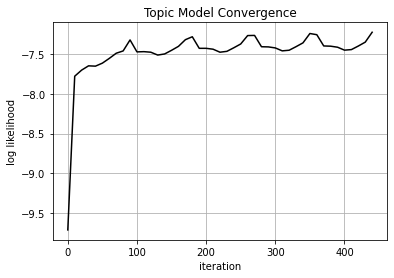

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import re

p = re.compile(r"(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open('../../data/gensim.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]
likelihood = [float(t[0]) for t in tuples]
perplexity = [float(t[1]) for t in tuples]
iter = list(range(0,len(tuples)*10,10))
plt.plot(iter,likelihood,c="black")
plt.ylabel("log likelihood")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()

 Note that the graph contains about 5 "peaks", which refers to the number of `passes` we set above. As you can see, the model converges quite rapidly, so we do not need to set `passes` very high.

<a id='coh'></a>

# Calculating Topic Coherence

We can also apply statistical measures to help us determine the optimal number of topics in our topic model.

**Topic Coherence** measures the score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. This helps to distinguish between topics that are semantically interpretable topics, and topics that are artifacts of statistical inference. 

A set of statements or facts is said to be coherent if the statements support each other. An example of a coherent fact set is “the game is a team sport”, “the game is played with a ball”, “the game demands great physical efforts”

A good model will generate topics with *high* topic coherence scores. Good topics are topics that can be described by a short label, therefore this is what the topic coherence measure should capture.

💡**Tip**: There are different ways to measure coherence. For instance, the c_v measure used here is calculated based on a combination of confirmation measures, such as how often word pairs occur together.

In [ ]:
#import logging
#logging.getLogger().setLevel(logging.CRITICAL)
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model_tweak, corpus=pos_corpus, texts=tqdm(pos_lemmas_split), dictionary=pos_dictionary, coherence='c_v') 
coherence = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence)

100%|███████████████████████████████████| 16309/16309 [00:04<00:00, 3288.01it/s]



Coherence Score:  0.41908494017566006


There's no hard or fast rule on what makes a good coherence score.
In general, a coherence score of .4 means you probably are not using the right number of topics. .6 to .7 is good. Anything more is suspiciously great. As you can see, our coherence score here is very low, so we should definitely try to improve upon our model.

<a id='topics'></a>
# Changing number of topics

The final and most important thing we can do to find optimal scores is to play around with the amount of topics our model creates. One way to do this is to build many LDA models with different values of number of topics (k), and then pick the one that gives the highest coherence value. Choosing a ‘k’ at the end of a rapid growth of topic coherence usually yields meaningful and interpretable topics. If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

This `compute_coherence_values()` function trains multiple LDA models, provides the models, and tells you their corresponding coherence scores.

Also note the docstring I create here: these are documentation for the functions we create. It describes what a function does, and can be called using `help(function_X)`.

In [53]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : Tokenized text (list of lis of str)
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    passes = 5
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, 
                         update_every=1, passes=passes, alpha='auto', per_word_topics=False)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        # When using 'c_v' texts should be provided, corpus isn’t needed. 
        # When using ‘u_mass’ corpus should be provided, if texts is provided, it will be converted to corpus using the dictionary 
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


Using our new function, let's run a bunch of topic models with different amounts of topics.

In [54]:
# Can take a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=pos_dictionary, 
                                                        corpus=pos_corpus, texts=pos_lemmas_split, 
                                                        start=5, limit=20, step=3)

100%|█████████████████████████████████████████████| 5/5 [01:25<00:00, 17.12s/it]


Now, from all those models, let's visualize the output of the coherence scores.

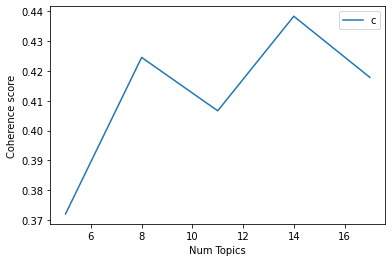

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

# Show graph
start=5; limit=20; step=3
x = range(start, limit, step) # range uses start, stop, and incrementation
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [56]:
# Print these coherence scores
c = 0
for m, cv in zip(x, coherence_values):
    print(f"model_list[{c}]: Num Topics = {m}, Coherence Value = {round(cv, 4)}")
    c += 1

model_list[0]: Num Topics = 5, Coherence Value = 0.3721
model_list[1]: Num Topics = 8, Coherence Value = 0.4245
model_list[2]: Num Topics = 11, Coherence Value = 0.4066
model_list[3]: Num Topics = 14, Coherence Value = 0.4383
model_list[4]: Num Topics = 17, Coherence Value = 0.4178


If the coherence score seems to keep increasing, it generally makes sense to pick the model that gave the highest CV before dropping again. Following this "elbow method", we have a few options.

However, these methods are only heuristics, and the scores we have here are not that far apart. At this point you should *go back* to pyLDAvis using the models from our `model_list`, and compare them to see which topic model looks better (i.e., non-overlapping bubbles spread across the chart with distinct top words). Based on these combined insights, I will pick the model with 8 topics.

Note that this is **not** the model with the highest coherence value! While these metrics can be useful, they should never be followed blindly. What matters more is the **interpretability** of topic models.

In [65]:
from gensim import corpora, models, similarities

# SAVE MODEL
optimal_lda_model = model_list[1]
optimal_lda_model.save('../../data/aita_pos_lda_optimal.model')


In [66]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(optimal_lda_model, pos_corpus, pos_dictionary)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.030110  0.102574       1        1  28.806986
6      0.109583  0.031695       2        1  15.302691
0      0.011422 -0.080858       3        1  14.559279
3      0.179962  0.081120       4        1  10.997047
1     -0.203358  0.034467       5        1   8.387309
4     -0.012264  0.081062       6        1   7.790643
2      0.045757 -0.253884       7        1   7.176692
7     -0.161212  0.003824       8        1   6.979353, topic_info=           Term          Freq         Total Category  logprob  loglift
260       money   7978.000000   7978.000000  Default  30.0000  30.0000
23     daughter  10872.000000  10872.000000  Default  29.0000  29.0000
1130    wedding   6092.000000   6092.000000  Default  28.0000  28.0000
48          mom  11956.000000  11956.000000  Default  27.0000  27.0000
190        food   4518.000000   4518.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
96          way    450.429891   6525.766183   Topic8  -5.2505  -0.0111
105     brother    430.782189   6367.440977   Topic8  -5.2951  -0.0311
318        plan    367.731837   2308.172410   Topic8  -5.4533   0.8254
12    boyfriend    387.630673   4305.190140   Topic8  -5.4006   0.2547
55       people    389.420165   9616.680168   Topic8  -5.3960  -0.5444

[612 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2183      1  0.014363    10k
2183      5  0.976717    10k
6325      4  0.988203    7th
6549      8  0.976223     8f
2371      5  0.982557      _
...     ...       ...    ...
144       5  0.036141  young
144       6  0.036910  young
144       7  0.003076  young
144       8  0.023453  young
1743      5  0.991700      £

[1704 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 1, 4, 2, 5, 3, 8])

In case you want to load these models from disk again:

In [68]:
# LOAD MODEL
optimal_lda_model = LdaModel.load('../../data/aita_pos_lda_optimal.model')

# LOAD DICT
pos_dictionary = corpora.Dictionary.load('../../data/aita_pos_lda.dict')

# LOAD CORPUS
pos_corpus = [pos_dictionary.doc2bow(text) for text in tqdm(pos_lemmas_split)]

100%|██████████████████████████████████| 16309/16309 [00:00<00:00, 46489.17it/s]


## Naming our topics

The next thing we should do is name our topics. This is the most important interpretative step in the process: after all, our model has no semantic knowledge of the data. We will print out the top words of each topic, then go over all of them and give them names.

In [69]:
from pprint import pprint

# Select the ideal model and print the topics
model_topics = optimal_lda_model.show_topics(formatted=False)
pprint(optimal_lda_model.print_topics(num_words=20))

[(0,
  '0.023*"room" + 0.017*"work" + 0.016*"home" + 0.015*"night" + 0.012*"hour" + '
  '0.011*"bed" + 0.010*"sleep" + 0.009*"morning" + 0.008*"minute" + '
  '0.008*"bathroom" + 0.008*"week" + 0.007*"bad" + 0.007*"wife" + '
  '0.007*"phone" + 0.007*"door" + 0.006*"house" + 0.006*"husband" + '
  '0.006*"problem" + 0.006*"issue" + 0.006*"boyfriend"'),
 (1,
  '0.074*"money" + 0.024*"job" + 0.021*"pay" + 0.014*"gift" + 0.014*"month" + '
  '0.013*"work" + 0.010*"college" + 0.009*"cost" + 0.009*"expensive" + '
  '0.008*"bill" + 0.007*"lot" + 0.006*"new" + 0.006*"good" + 0.006*"income" + '
  '0.006*"stuff" + 0.006*"week" + 0.006*"house" + 0.006*"account" + '
  '0.005*"saving" + 0.005*"half"'),
 (2,
  '0.049*"food" + 0.040*"dog" + 0.022*"dinner" + 0.019*"cat" + 0.015*"meal" + '
  '0.009*"restaurant" + 0.009*"cook" + 0.009*"people" + 0.008*"home" + '
  '0.007*"table" + 0.007*"dish" + 0.007*"order" + 0.007*"eat" + 0.007*"cake" + '
  '0.006*"meat" + 0.006*"vegan" + 0.006*"animal" + 0.006*"lunch" 

**Important**: If you are using your own data, make sure to replace the following names with those of your own!

In [131]:
# giving names to our topics
topic_names = {0: 'home, everyday life', 
               1: 'expenses',
               2: 'food, pets',
               3: 'interpersonal',
               4: 'school, work',
               5: 'family',
               6: 'celebration, dating',
               7: 'car, home'
              }

Naming topics is a heavily iterative process, based on looking closer at particular posts (see below).

For instance, I had initially named topic 1 "weddings", but after reading some posts with this dominant topic, I renamed it to "married life, neighborhoods, pets".

<a id='use'></a>

# Using Topic Models

Topic modeling has several practical applications. One of them is to determine what topic a Reddit post is about. To figure this out, we find the topic number that has the highest percentage contribution to that thread. We'll write a `dominant_topic()` function that aggregates this information in a DataFrame.

In [132]:
def dominant_topic(ldamodel=optimal_lda_model, corpus=corpus, texts=df['selftext']):
    # Create DF
    topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each thread
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                # get value of topic_names dict based on key
                topic_name = topic_names[topic_num]
                topic_keywords = ", ".join([word for word, prop in wp])
                new_row = pd.DataFrame([[int(topic_num), topic_name, round(prop_topic,4), topic_keywords]])
                topics_df = pd.concat([topics_df, new_row], ignore_index=True)

            else:
                break
    topics_df.columns = ['Dominant_Topic', 'Dominant_Topic_Name', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    topics_df = pd.concat([topics_df, contents], axis=1)
    return topics_df 

# Run function
df_topic_keywords = dominant_topic(ldamodel=optimal_lda_model, corpus=pos_corpus, texts=df['selftext'])

# Format
df_dominant_topic = df_topic_keywords.reset_index(drop=True)
df_dominant_topic.columns = ['Dominant_Topic', 'Dominant_Topic_Name', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Dominant_Topic,Dominant_Topic_Name,Topic_Perc_Contrib,Keywords,Text
0,6,"celebration, dating",0.6127,"friend, wedding, people, dress, boyfriend, bir...",My girlfriend recently went to the beach with ...
1,5,family,0.4497,"mom, family, kid, sister, parent, husband, wif...",My parents smoke like chimneys. I used to as w...
2,0,"home, everyday life",0.3953,"room, work, home, night, hour, bed, sleep, mor...",Hi guys. Throwaway for obv reasons.\n\nI'm a f...
3,2,"food, pets",0.8797,"food, dog, dinner, cat, meal, restaurant, cook...","Yesterday night, me and my GF decided to go ou..."
4,2,"food, pets",0.3501,"food, dog, dinner, cat, meal, restaurant, cook...","My wife and I are vegetarians, much to my in-l..."
...,...,...,...,...,...
16304,1,expenses,0.6640,"money, job, pay, gift, month, work, college, c...",My (29m) good friend (26f) is currently house ...
16305,6,"celebration, dating",0.4606,"friend, wedding, people, dress, boyfriend, bir...",So I have a Degree in Fashion which some peopl...
16306,5,family,0.6960,"mom, family, kid, sister, parent, husband, wif...",My husband and I have been friends since middl...
16307,5,family,0.4561,"mom, family, kid, sister, parent, husband, wif...",I (30F) and my husband (30M) recently moved in...


We can now find the posts with a dominant topic using `.loc`

In [133]:
df_dominant_topic.loc[df_dominant_topic['Dominant_Topic_Name'] == 'expenses']['Text']

6        He has no money until he’s paid at the end of ...
46       About 6 months ago my trusty 2001 Corolla was ...
86       My boyfriend and I exchanged presents early be...
92       I live with my best friend (let’s call her Ste...
97       An acquaintance of mine helps run a charity an...
                               ...                        
16241    Adding this after the post: Ok thank you to ev...
16262    I (38f) lost my job last year and since then I...
16291    This happened before campus closed but we usua...
16296    So this is what happened. My son who is 15 app...
16304    My (29m) good friend (26f) is currently house ...
Name: Text, Length: 1061, dtype: object

Look at the first post:

In [134]:
df_dominant_topic.loc[df_dominant_topic['Dominant_Topic_Name'] == 'expenses']['Text'][6]

'He has no money until he’s paid at the end of the month and he told me I wouldn’t get a present until then and I’m completely fine with that but I didn’t even receive a card. I don’t expect expensive gifts but I’d of liked a card. Even when I’ve got no money I either borrow it until I get paid or I at least get him a card and explain I’ll get him something when I’m paid. I thought he’d do the same. But no. Today I woke up with nothing at all. I didn’t say anything and acted like I’m fine and he’s currently at work but still. We’re trying to save money because We’re expecting our first kid in a few months but I just feel like he doesn’t care at all. Even last year he waited till the night before to go get something and only because I said it was my 18th and I felt like nobody cared since no one mentioned it or took notice when it came up in conversation.\n\nI haven’t spoken to him since he left this morning, even ignoring his texts and calls. Am I the asshole in this situation?? '

That does look to be about expenses.

## Adding topics to original DF

Once we are happy with your topic names, we can add the dominant topic names to our original DataFrame and save it.

In [135]:
df['dom_topic'] = df_dominant_topic['Dominant_Topic_Name']
df['dom_topic_num'] = df_dominant_topic['Dominant_Topic']

df.to_csv('../../data/aita_lda.csv', index=False)

In [136]:
df.head(3)

,idint,idstr,created,self,nsfw,author,title,url,selftext,score,...,distinguish,textlen,num_comments,flair_text,flair_css_class,augmented_at,augmented_count,pp_text,dom_topic,dom_topic_num
0,427576402,t3_72kg2a,1506433689,1.0,0.0,Ritsku,AITA for breaking up with my girlfriend becaus...,NaN,My girlfriend recently went to the beach with ...,679.0,...,NaN,4917.0,434.0,no a--holes here,NaN,NaN,NaN,girlfriend recently went beach friends tiny bi...,"celebration, dating",6
1,551887974,t3_94kvhi,1533404095,1.0,0.0,hhhhhhffff678,AITA for banning smoking in my house and telli...,NaN,My parents smoke like chimneys. I used to as w...,832.0,...,NaN,2076.0,357.0,asshole,ass,NaN,NaN,parents smoke like chimneys quit wife got youn...,family,5
2,552654542,t3_951az2,1533562299,1.0,0.0,creepatthepool,AITA? Creep wears skimpy bathing suit to pool,NaN,Hi guys. Throwaway for obv reasons.\n\nI'm a f...,23.0,...,NaN,1741.0,335.0,Shitpost,NaN,NaN,NaN,hi guys throwaway obv reasons i'm female child...,"home, everyday life",0


# Topic Co-occurrence

We only added the "dominant topic" (i.e., the topic with the highest probability) to our DataFrame, but we should remember that topic models assign probabilities for all topics across all documents. 

This means we could also create a network graph that displays co-occurring topics. For each document, we check the topics This is especially helpful if you have named your topics, as it allows you to see which of the themes frequently seem to occur together.

In [162]:
# Number of topics
num_topics = optimal_lda_model.num_topics

# Initialize the overlap matrix
overlap_matrix = np.zeros((num_topics, num_topics))

# Iterate through documents and get topic probabilities
for document in tqdm(pos_corpus, desc="Processing documents"):
    document_topics = optimal_lda_model.get_document_topics(document, minimum_probability=0)
    # Create a full topic distribution for the document
    full_topic_distribution = [0] * num_topics
    for topic_num, prob in document_topics:
        full_topic_distribution[topic_num] = prob

    # Iterate through pairs of topics and add probabilities to the overlap matrix
    for i in range(num_topics):
        for j in range(num_topics):
            overlap_matrix[i, j] += full_topic_distribution[i] * full_topic_distribution[j]

# Normalize the overlap matrix by dividing by the number of documents
overlap_matrix /= len(pos_corpus)

# Assuming overlap_matrix is your overlap matrix
np.fill_diagonal(overlap_matrix, 0)

# Now apply the threshold
co_occurrence_matrix = np.where(overlap_matrix > 0.01, overlap_matrix, 0)


Processing documents: 100%|█████████████| 16309/16309 [00:02<00:00, 6941.36it/s]


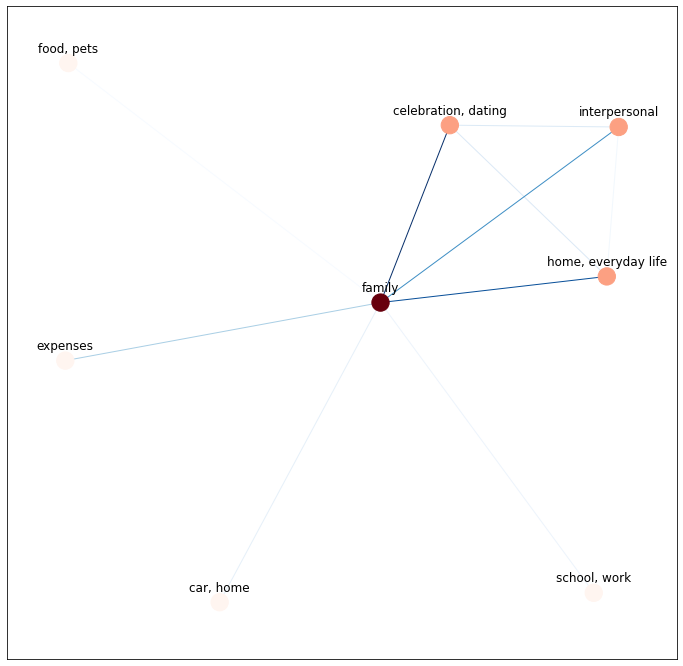

In [164]:
# Create a graph from the co-occurrence matrix
G = nx.Graph()
for i in range(co_occurrence_matrix.shape[0]):
    for j in range(co_occurrence_matrix.shape[1]):
        if co_occurrence_matrix[i, j] > 0:
            G.add_edge(i, j, weight=co_occurrence_matrix[i, j])

# Define node colors based on the number of links remaining after removal
node_colors = [len(list(G.neighbors(n))) for n in G.nodes()]

# Define edge colors based on co-occurrence strength
edge_colors = [d['weight'] for _, _, d in G.edges(data=True)]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  # Can use other layouts as well

# Define an offset for the labels
label_offset = 0.05

# Create a new dictionary for the label positions
label_pos = {node: (coordinates[0], coordinates[1] + label_offset) for node, coordinates in pos.items()}

nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.Reds)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.Blues)
nx.draw_networkx_labels(G, label_pos, labels=topic_names)

plt.show()


# 💭 Reflection: The hermeneutics of topic modeling 

One thought to end with: for most topic models you will create, it will be hard to apply a meaningful interpretation to each topic. Not every topic will have some meaningful insight "fall out of it" upon first inspection. This is a typical issue in machine learning, which can pick up on patterns that might not make sense to humans.

It is an open question to which extent you should let yourself be surprised by particular combinations of words in a topic, or if topic models primarily should follow the intuitions you already have as a researcher. What makes for a "good" topic model probably straddles the boundaries of surprise and expectation.

<div class="alert alert-success">

## ❗ Key Points

* Topic modeling can help us find themes and topics in textual data.
* Topic models can be evaluated and improved based on coherence metrics; however, using your eyes to see whether topics make intuitive sense is just as important.
* Topic models yield information that can be used to do different things, such as finding submissions with particular topics, or classifying texts.
    
</div>